In [85]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler


In [86]:
# Load the dataset
file_path = "GlobalElectricityStatistics.csv"
electricity_data = pd.read_csv(file_path)

# Display the first and last five rows of the DataFrame
print("First five rows:")
print(electricity_data.head())

print("\nLast five rows:")
print(electricity_data.tail())

# Show basic information about the DataFrame
print("\nBasic dataset information:")
print(f"Dataset dimensions: {electricity_data.shape}")
print("\nColumn details:")
print(electricity_data.info())

print("\nData types and memory usage:")
print(electricity_data.info(memory_usage='deep'))

print("\nStatistical summary of the data:")
print(electricity_data.describe())

# Check for missing values
print("\nMissing values check:")
missing_values = electricity_data.isnull().sum()
print(f"Number of missing values per column:\n{missing_values}")
print(f"Total number of missing values: {electricity_data.isnull().sum().sum()}")
print(f"Percentage of missing values: {(electricity_data.isnull().sum().sum() / (electricity_data.shape[0] * electricity_data.shape[1])) * 100:.2f}%")

# Handle missing values
# 1. Fill numeric missing data with 0 (assuming missing means no data or zero)
electricity_data_cleaned = electricity_data.fillna(0)

# 2. Check if any missing values remain
print("\nMissing values check after handling:")
print(f"Total remaining missing values: {electricity_data_cleaned.isnull().sum().sum()}")

# 3. Check for inconsistencies in the data - e.g., non-numeric values in numeric columns
# Assume all columns from the fourth onward represent yearly data
numeric_columns = electricity_data.columns[3:]
non_numeric_data = electricity_data[numeric_columns].map(lambda x: not pd.api.types.is_numeric_dtype(type(x)) and not pd.isna(x))
non_numeric_count = non_numeric_data.sum().sum()

print("\nNon-numeric data detection:")
print(f"Number of non-numeric entries in numeric columns: {non_numeric_count}")

if non_numeric_count > 0:
    # Show sample locations of non-numeric values
    print("Sample positions of non-numeric data:")
    for col in numeric_columns:
        non_numeric_in_col = electricity_data[non_numeric_data[col]][col]
        if len(non_numeric_in_col) > 0:
            print(f"Non-numeric values in column '{col}': {non_numeric_in_col.iloc[0:5].tolist() if len(non_numeric_in_col) > 5 else non_numeric_in_col.tolist()}")

    # Convert non-numeric values to NaN and fill them with 0
    for col in numeric_columns:
        electricity_data_cleaned[col] = pd.to_numeric(electricity_data[col], errors='coerce').fillna(0)

print("\nFirst five rows of cleaned data:")
print(electricity_data_cleaned.head())

# Save the cleaned data
electricity_data_cleaned.to_csv("GlobalElectricityStatistics_cleaned.csv", index=False)
print("\nCleaned data has been saved as 'GlobalElectricityStatistics_cleaned.csv'")

First five rows:
          Country              Features          Region     1980     1981  \
0     Afghanistan  distribution losses   Asia & Oceania  0.06594  0.06944   
1         Albania  distribution losses           Europe  0.16100  0.16100   
2         Algeria  distribution losses           Africa  0.77700  0.95400   
3  American Samoa  distribution losses   Asia & Oceania  0.00490  0.00469   
4          Angola  distribution losses           Africa  0.16900  0.16900   

      1982     1983     1984     1985     1986  ...     2012      2013  \
0  0.06664  0.07000  0.07133  0.07238  0.07945  ...   0.4040   0.49000   
1  0.16100  0.16000  0.16000  0.16100  0.16200  ...   1.1193   1.95349   
2  1.06500  1.39000  1.64900  1.84600  1.85400  ...  11.0680  11.02300   
3  0.00469  0.00497  0.00483  0.00581  0.00525  ...   0.0000   0.00000   
4  0.18000  0.19600  0.16800  0.20200  0.20200  ...   0.6990   0.92600   

       2014    2015     2016       2017      2018      2019      2020  \
0 

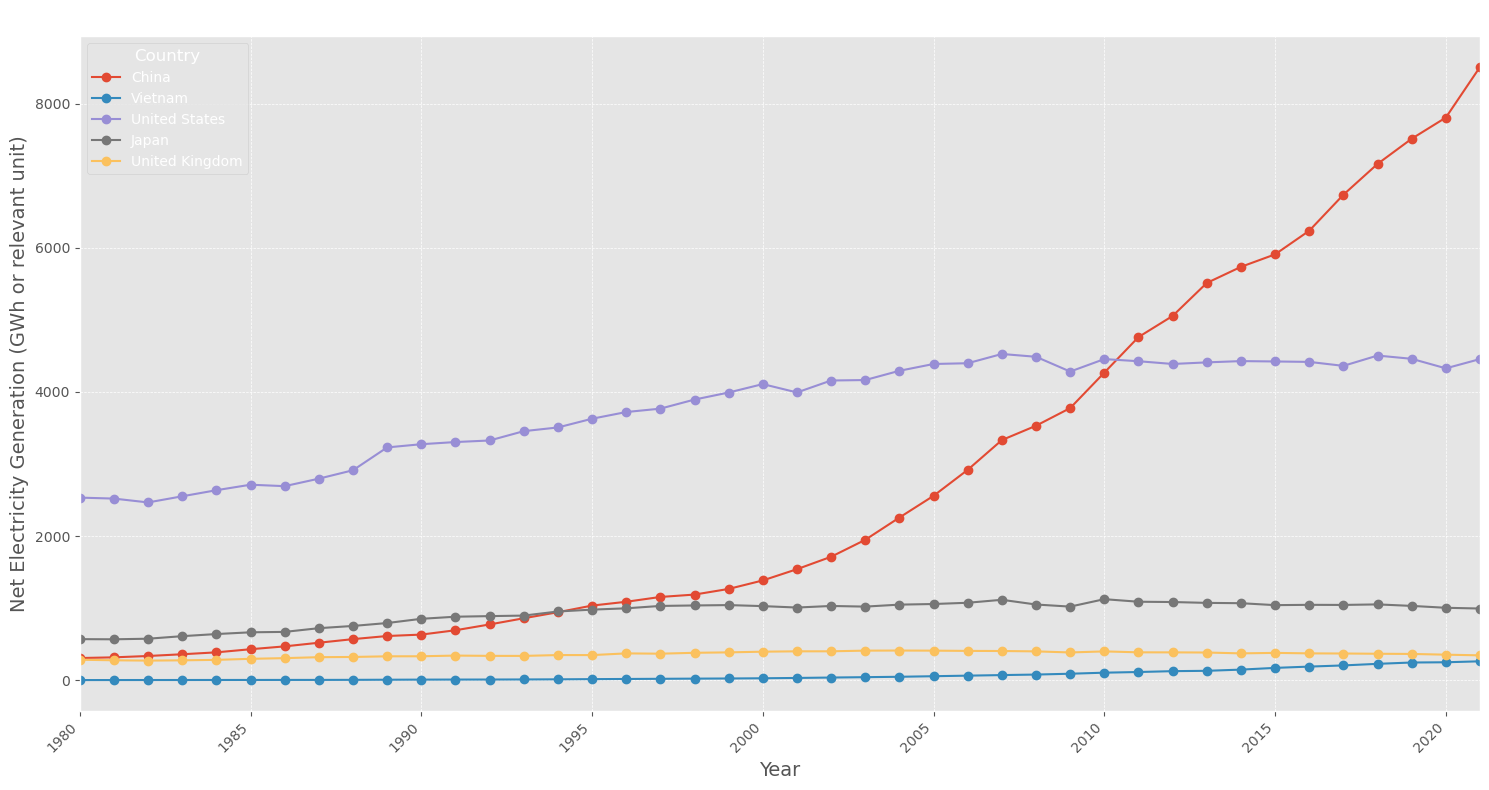

In [87]:
# Data Visualization: Electricity Generation Trends for Selected Countries

# Select specified countries
selected_countries = ['China', 'Vietnam', 'United States', 'Japan', 'United Kingdom']
electricity_viz_data = electricity_data_cleaned[electricity_data_cleaned['Country'].isin(selected_countries)]

# Select year columns from 1980 to 2021
# Get all numeric columns and identify those that represent years
year_columns_to_check = [col for col in electricity_viz_data.columns if col.isdigit() or (isinstance(col, str) and col.isnumeric())]

# Filter for years between 1980 and 2021 and ensure they exist in the DataFrame
years_to_plot_str = [str(year) for year in range(1980, 2022)]
years_present = [col for col in years_to_plot_str if col in electricity_viz_data.columns]

# Prepare plotting data
# Group by country and sum values across years to ensure one value per country per year
aggregated_data = electricity_viz_data.groupby('Country')[years_present].sum()

# Transpose data for plotting: years as index, countries as columns
plot_data = aggregated_data.T
plot_data.index = plot_data.index.astype(int)  # Convert year index to int for correct sorting

# Plot line chart
plt.figure(figsize=(15, 8))

for country in selected_countries:
    if country in plot_data.columns:
        plt.plot(plot_data.index, plot_data[country], label=country, marker='o', linestyle='-')

# Add title and labels
plt.title('Net Electricity Generation Trend (1980-2021) for Selected Countries', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Net Electricity Generation (GWh or relevant unit)', fontsize=14)
plt.legend(title='Country', fontsize=10, title_fontsize='12')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels to avoid overlap
plt.xlim(1980, 2021)  # Set x-axis limits
plt.tight_layout()
plt.show()

Duplicate country entries detected. Aggregating data by country...

Average Annual Electricity Generation (2000–2021) by Country:
                   Country  Average Generation (2000-2021)
40                   China                     4553.179078
219          United States                     4357.464005
98                   India                     1262.613957
169                 Russia                     1101.134016
106                  Japan                     1052.471425
..                     ...                             ...
71       Former Yugoslavia                        0.000000
70         Former U.S.S.R.                        0.000000
133             Micronesia                        0.000000
68   Former Czechoslovakia                        0.000000
93     Hawaiian Trade Zone                        0.000000

[230 rows x 2 columns]

Country with the Highest Average Generation (2000–2021):
Country                                 China
Average Generation (2000-2021)    

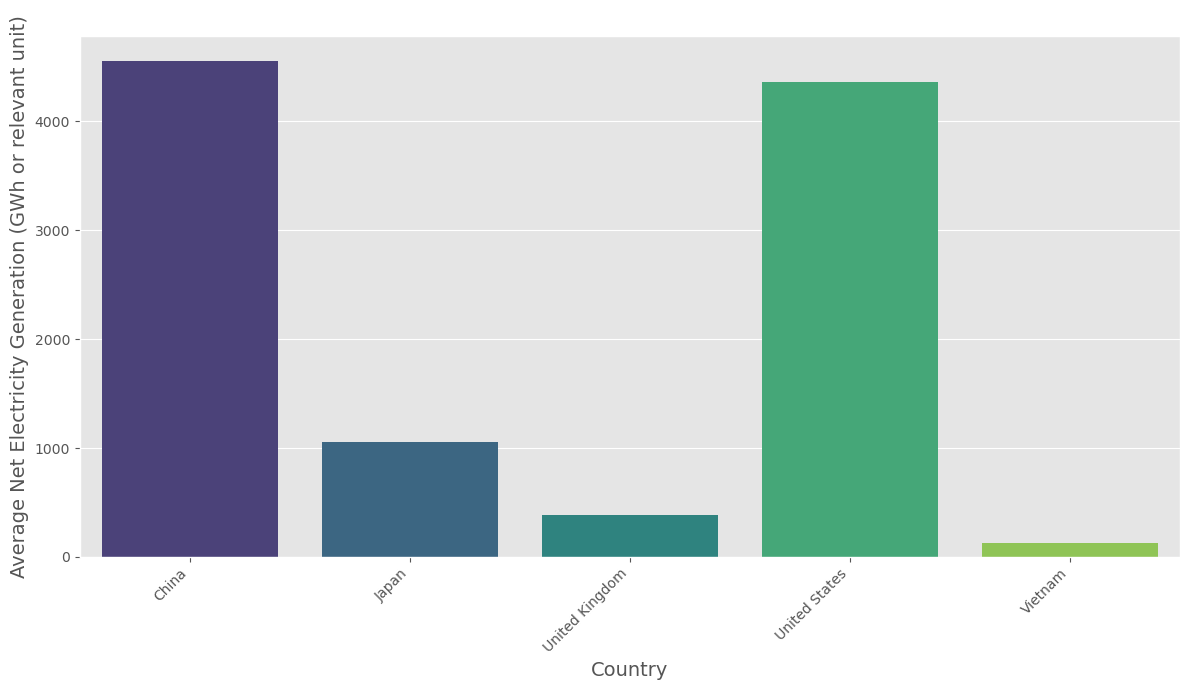

In [88]:
# 1.3 Data Aggregation and Summary

# a. Calculate and display the average annual electricity generation for each country from 2000 to 2021

# First, ensure the year columns are correctly identified
years_for_avg_str = [str(year) for year in range(2000, 2022)]

# Filter out only those year columns that exist in the cleaned data and are numeric
years_present_for_avg = [
    col for col in years_for_avg_str 
    if col in electricity_data_cleaned.columns and pd.api.types.is_numeric_dtype(electricity_data_cleaned[col])
]

if not years_present_for_avg:
    print("Error: No numeric year data found for 2000–2021 in the dataset.")
else:
    # Select only the relevant year columns and 'Country'
    avg_electricity_data = electricity_data_cleaned[['Country'] + years_present_for_avg].copy()  # Use .copy() to avoid SettingWithCopyWarning

    # If there are duplicate country entries (e.g., multiple regions or types), aggregate them
    if avg_electricity_data['Country'].duplicated().any():
        print("Duplicate country entries detected. Aggregating data by country...")
        # Sum numeric columns per country
        numeric_cols_to_sum = [col for col in years_present_for_avg if pd.api.types.is_numeric_dtype(avg_electricity_data[col])]
        if not numeric_cols_to_sum:
            print("Warning: No numeric year columns found for aggregation.")
        avg_electricity_data = avg_electricity_data.groupby('Country', as_index=False)[numeric_cols_to_sum].sum()

    # Compute average generation across selected years
    avg_electricity_data['Average Generation (2000-2021)'] = avg_electricity_data[years_present_for_avg].mean(axis=1)

    # Display results sorted by average generation
    print("\nAverage Annual Electricity Generation (2000–2021) by Country:")
    avg_generation_sorted = avg_electricity_data[['Country', 'Average Generation (2000-2021)']].sort_values(
        by='Average Generation (2000-2021)', ascending=False)
    print(avg_generation_sorted)

    # b. Identify and display the countries with the highest and lowest average generation
    highest_avg_country = avg_electricity_data.loc[avg_electricity_data['Average Generation (2000-2021)'].idxmax()]

    # Filter non-zero average data to find the minimum (excluding zero values)
    non_zero_avg_data = avg_electricity_data[avg_electricity_data['Average Generation (2000-2021)'] > 0]
    if not non_zero_avg_data.empty:
        lowest_avg_country = non_zero_avg_data.loc[non_zero_avg_data['Average Generation (2000-2021)'].idxmin()]
    else:
        # Create a fallback Series if all averages are zero
        lowest_avg_country = pd.Series({
            'Country': "N/A (All countries have zero or missing average generation)",
            'Average Generation (2000-2021)': 0.0
        })

    print("\nCountry with the Highest Average Generation (2000–2021):")
    print(highest_avg_country[['Country', 'Average Generation (2000-2021)']])
    print("\nCountry with the Lowest Non-Zero Average Generation (2000–2021):")
    print(lowest_avg_country[['Country', 'Average Generation (2000-2021)']])

    # c. Visualize the average generation comparison for selected countries
    avg_selected_countries_data = avg_electricity_data[avg_electricity_data['Country'].isin(selected_countries)]

    plt.figure(figsize=(12, 7))
    sns.barplot(x='Country', y='Average Generation (2000-2021)', data=avg_selected_countries_data,
                palette='viridis', hue='Country', legend=False)
    plt.title('Average Electricity Generation (2000–2021) for Selected Countries', fontsize=16)
    plt.xlabel('Country', fontsize=14)
    plt.ylabel('Average Net Electricity Generation (GWh or relevant unit)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

Columns in the original dataset: ['Country', 'Features', 'Region', '1980', '1981', '1982', '1983', '1984', '1985', '1986'] ...
Unique values in the 'Features' column of the original dataset:
['distribution losses ' 'exports ' 'imports ' 'net generation']
Number of net generation records: 230
Number of import records: 230
Number of export records: 230
Number of distribution loss records: 230

Total number of countries/regions: 230

First few rows of annual net consumption data by country:
          Country     1980     1981     1982     1983     1984
0     Afghanistan  0.87606  0.92256  0.88536  0.93000  0.94767
1         Albania  2.97400  2.98700  2.98100  2.97500  2.97700
2         Algeria  5.91500  6.71300  7.73300  8.20700  8.95900
3  American Samoa  0.06510  0.06231  0.06231  0.06603  0.06417
4          Angola  0.73600  0.73700  0.81500  0.83200  0.86000

Top 10 countries by average net electricity consumption:
             Country  Average Net Consumption
219    United States     

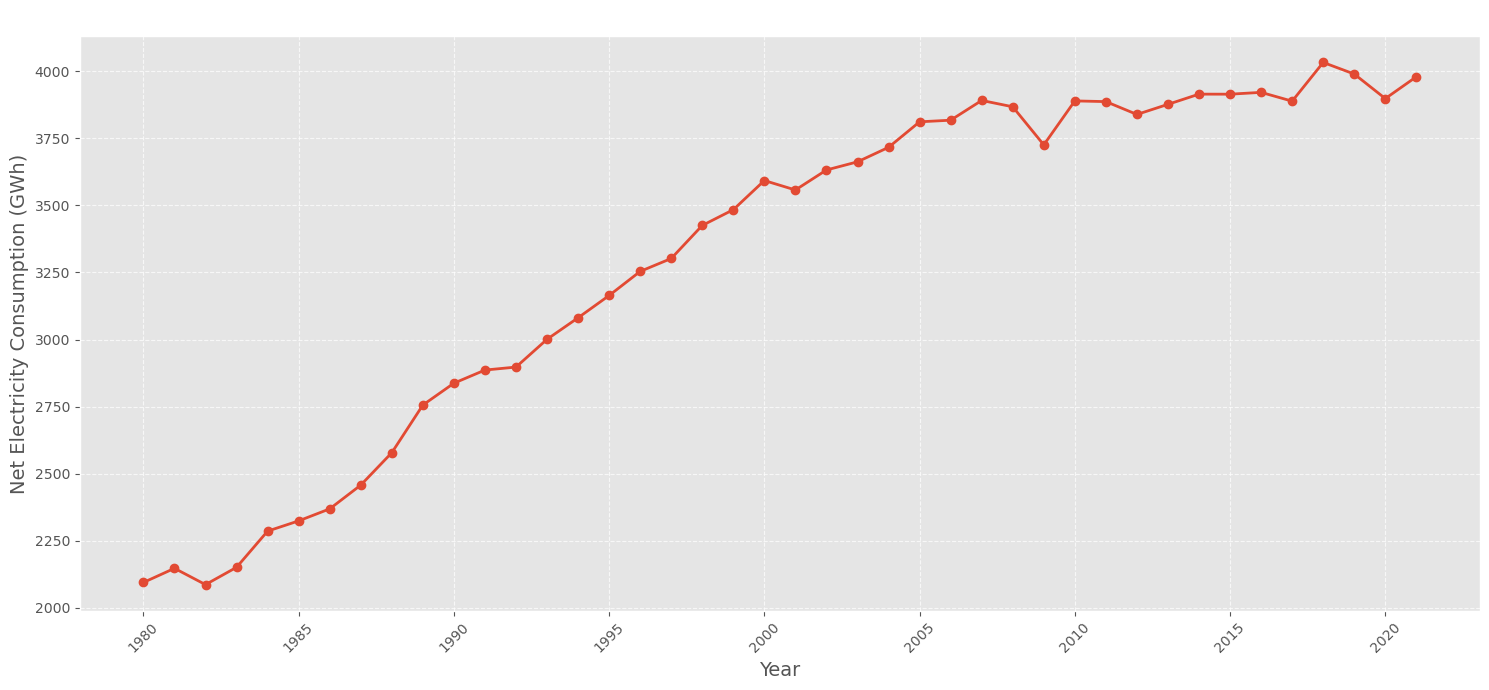


Head of time series data:
   Year  Net Consumption
0  1980      2094.449000
1  1981      2147.102862
2  1982      2086.441352
3  1983      2150.954584
4  1984      2285.796394
    Year  Net Consumption
37  2017      3888.305646
38  2018      4032.628268
39  2019      3989.378249
40  2020      3897.894198
41  2021      3979.279761

Training set size: 33 samples (78.6%)
Testing set size: 9 samples (21.4%)


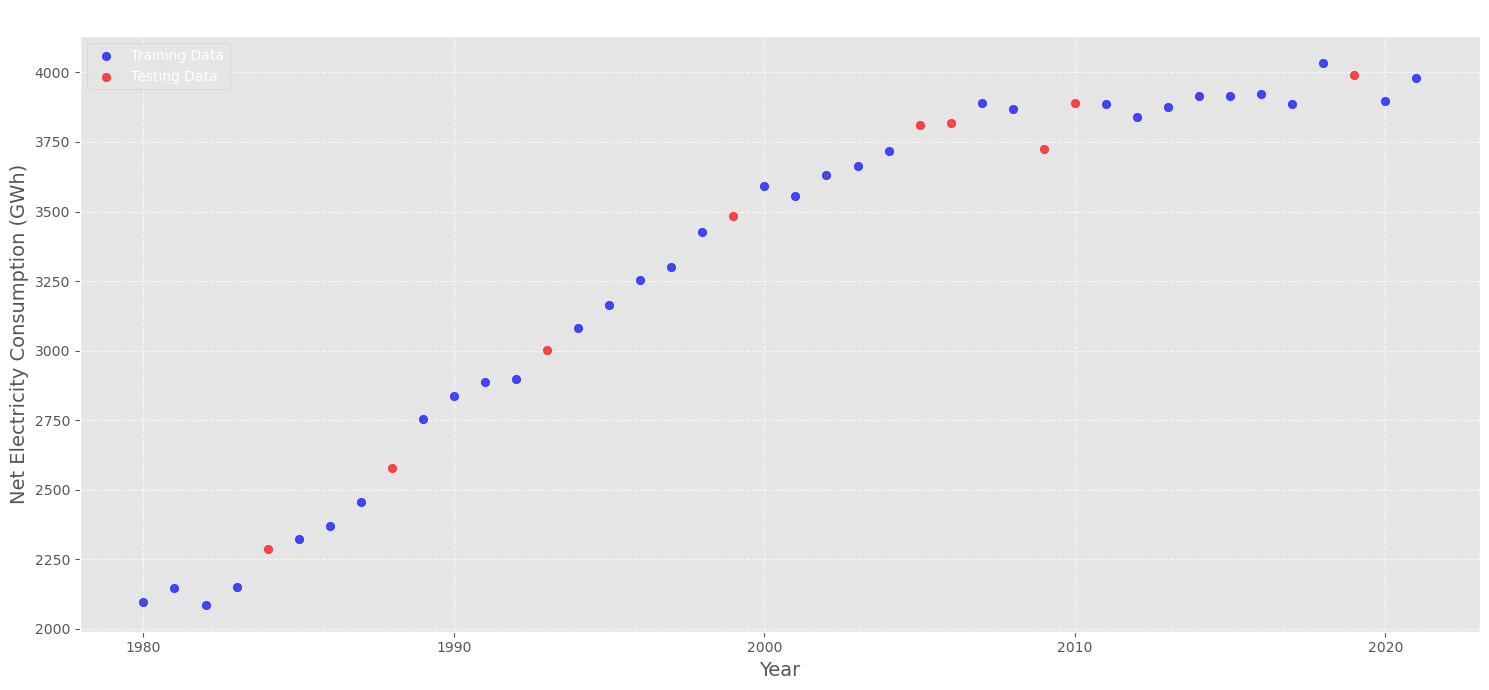

In [89]:
# Task 2: Prediction Modeling and Discussion

# 2.1 Data Preparation for Prediction

# Read the original dataset, as we need the type information (in case it's not present in cleaned data)
original_data = pd.read_csv("GlobalElectricityStatistics.csv")
print("Columns in the original dataset:", original_data.columns[:10].tolist(), "...")

# Check unique values in the 'Features' column which contains the type of data
print("Unique values in the 'Features' column of the original dataset:")
print(original_data['Features'].unique())

# Filter different types of data and create separate datasets
net_generation_data = original_data[original_data['Features'].str.strip().str.lower() == 'net generation'].copy()
imports_data = original_data[original_data['Features'].str.strip().str.lower() == 'imports'].copy()
exports_data = original_data[original_data['Features'].str.strip().str.lower() == 'exports'].copy()
distribution_losses_data = original_data[original_data['Features'].str.strip().str.lower() == 'distribution losses'].copy()

# Display number of records per type
print(f"Number of net generation records: {len(net_generation_data)}")
print(f"Number of import records: {len(imports_data)}")
print(f"Number of export records: {len(exports_data)}")
print(f"Number of distribution loss records: {len(distribution_losses_data)}")

# a. Calculate net consumption values for each country from 1980 to 2021
# Net Consumption = Net Generation + Imports - Exports - Distribution Losses

# Get list of years (1980–2021)
year_columns = [str(year) for year in range(1980, 2022)]

# Get list of all unique countries
all_countries = pd.unique(original_data['Country'])
print(f"\nTotal number of countries/regions: {len(all_countries)}")

# Create an empty DataFrame to store net consumption results
net_consumption_df = pd.DataFrame(index=all_countries)

# Function to retrieve value for a given country and year
def get_value_for_country_year(df, country, year):
    try:
        value = df[df['Country'] == country][year].values
        return float(value[0]) if len(value) > 0 else 0
    except Exception:
        return 0

# For each year, compute net consumption for all countries
for year in year_columns:
    year_consumption = []
    
    for country in all_countries:
        # Retrieve data for each category
        net_gen = get_value_for_country_year(net_generation_data, country, year)
        imports = get_value_for_country_year(imports_data, country, year)
        exports = get_value_for_country_year(exports_data, country, year)
        losses = get_value_for_country_year(distribution_losses_data, country, year)
        
        # Compute net consumption
        net_consumption = net_gen + imports - exports - losses
        year_consumption.append(net_consumption)
    
    # Add yearly data to the result DataFrame
    net_consumption_df[year] = year_consumption

# Reset index and add 'Country' column
net_consumption_df.reset_index(inplace=True)
net_consumption_df.rename(columns={'index': 'Country'}, inplace=True)

# Display first few rows of net consumption data
print("\nFirst few rows of annual net consumption data by country:")
print(net_consumption_df[['Country'] + year_columns[:5]].head())

# b. Select the country with the highest average net consumption

# Compute average net consumption for each country
net_consumption_df['Average Net Consumption'] = net_consumption_df[year_columns].mean(axis=1)

# Sort and display top 10 countries by average net consumption
top_countries = net_consumption_df.sort_values('Average Net Consumption', ascending=False).head(10)
print("\nTop 10 countries by average net electricity consumption:")
print(top_countries[['Country', 'Average Net Consumption']])

# Get the country with the highest average net consumption
top_country = top_countries.iloc[0]['Country']
top_country_avg = top_countries.iloc[0]['Average Net Consumption']
print(f"\nThe country with the highest average net consumption is: {top_country}")
print(f"Average net consumption: {top_country_avg:.2f} GWh")

# Plot net consumption trend for the top country
plt.figure(figsize=(15, 7))
top_country_data = net_consumption_df[net_consumption_df['Country'] == top_country]
years = [int(year) for year in year_columns]
values = [top_country_data[year].values[0] for year in year_columns]

plt.plot(years, values, marker='o', linewidth=2)
plt.title(f'{top_country} Net Electricity Consumption (1980–2021)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Net Electricity Consumption (GWh)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(years[::5], rotation=45)  # Show every 5 years
plt.tight_layout()
plt.show()

# c. Split net consumption data into training and testing sets for the selected country
from sklearn.model_selection import train_test_split

# Prepare time series data
time_series_data = pd.DataFrame({
    'Year': years,
    'Net Consumption': values
})
print("\nHead of time series data:")
print(time_series_data.head())
print(time_series_data.tail())

# Split into training and testing sets (80% train, 20% test)
X = time_series_data[['Year']]
y = time_series_data['Net Consumption']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

print(f"\nTraining set size: {len(X_train)} samples ({(len(X_train)/len(X))*100:.1f}%)")
print(f"Testing set size: {len(X_test)} samples ({(len(X_test)/len(X))*100:.1f}%)")

# Visualize the split
plt.figure(figsize=(15, 7))
plt.scatter(X_train, y_train, color='blue', label='Training Data', alpha=0.7)
plt.scatter(X_test, y_test, color='red', label='Testing Data', alpha=0.7)
plt.title(f'Training and Testing Data Split for {top_country}', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Net Electricity Consumption (GWh)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

2.2 Model Construction and Prediction
Using device: cuda

Training data shape: torch.Size([33, 1]), torch.Size([33, 1])
Testing data shape: torch.Size([9, 1]), torch.Size([9, 1])

Initializing enhanced MLP model with multiple hidden layers...

MLP Model Architecture:
MLPModel(
  (fc1): Linear(in_features=1, out_features=64, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=64, bias=True)
  )
  (fc_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)
Model has 82689 trainable parameters

Training and evaluating enhanced MLP model:

Training MLP model with increased capacity...
X_train_tensor shape: torch.Size([33, 1]), y_train_tensor shape: torch.Size([33, 1])
数据检查通过：没有发现NaN或无穷值
分割训练集 (31) 和验证集 (2)
Early

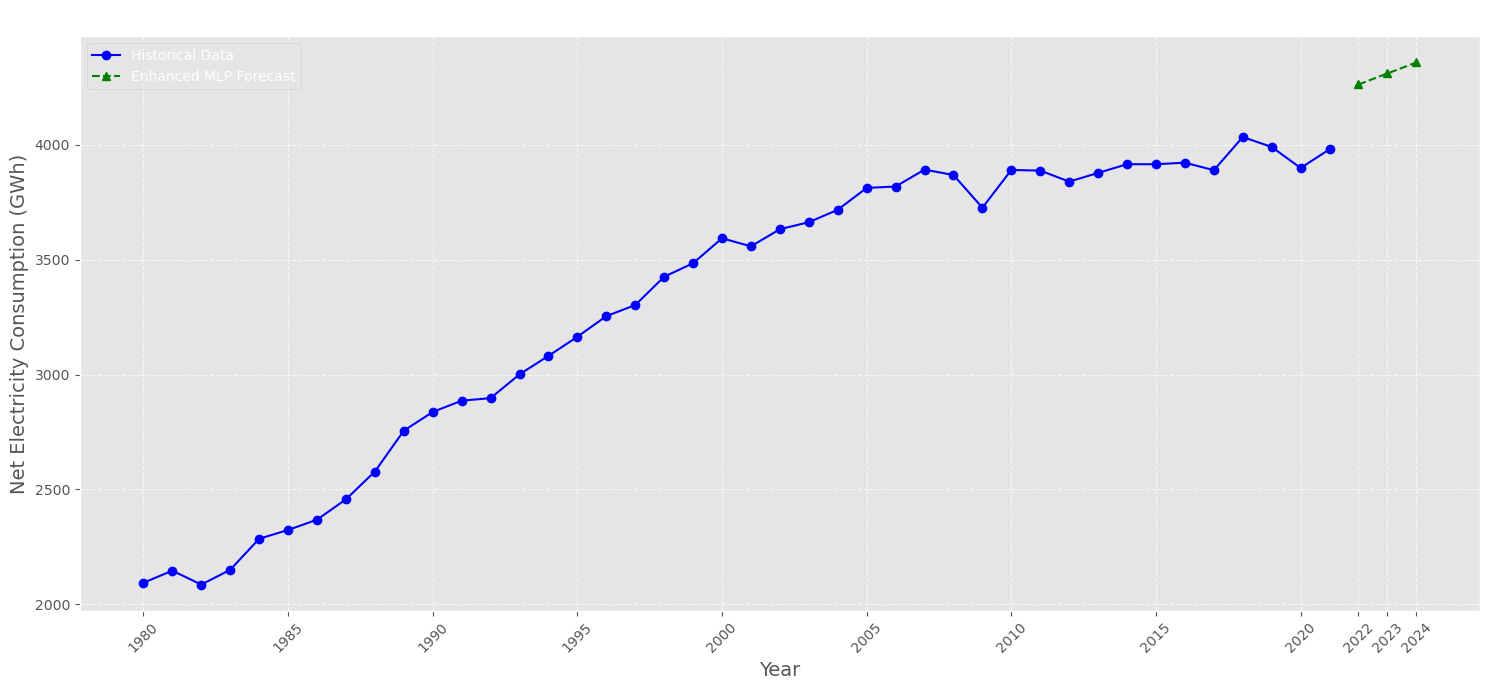

In [90]:
# 2.2 Model Construction and Prediction
print("2.2 Model Construction and Prediction")

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Data preprocessing
# Normalize the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Reorganize the data and sort by year (since random split was used before, now we need chronological order)
ordered_data = time_series_data.sort_values(by='Year')
X_ordered = ordered_data[['Year']].values
y_ordered = ordered_data['Net Consumption'].values

# Normalize the data
X_scaled = scaler_X.fit_transform(X_ordered.reshape(-1, 1))
y_scaled = scaler_y.fit_transform(y_ordered.reshape(-1, 1))

# Split into training and testing sets (80% train, 20% test), maintaining time order
split_idx = int(len(X_scaled) * 0.8)
X_train_ordered = X_scaled[:split_idx]
X_test_ordered = X_scaled[split_idx:]
y_train_ordered = y_scaled[:split_idx]
y_test_ordered = y_scaled[split_idx:]

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_ordered).to(device)
y_train_tensor = torch.FloatTensor(y_train_ordered).to(device)
X_test_tensor = torch.FloatTensor(X_test_ordered).to(device)
y_test_tensor = torch.FloatTensor(y_test_ordered).to(device)

print(f"\nTraining data shape: {X_train_tensor.shape}, {y_train_tensor.shape}")
print(f"Testing data shape: {X_test_tensor.shape}, {y_test_tensor.shape}")

# a. Initialize MLP model

# MLP Model with increased capacity - 完全修复版
class MLPModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dims=[64, 128, 128, 64], output_dim=1, dropout_rate=0.2):
        super(MLPModel, self).__init__()
        
        # 直接定义每个层，而不使用Sequential
        # 第一层 - 输入层到第一个隐藏层
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        
        # 中间层
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            self.hidden_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
        
        # 输出层
        self.fc_out = nn.Linear(hidden_dims[-1], output_dim)
        
        # 激活函数和正则化
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        
        # 初始化权重 (Xavier/Glorot initialization)
        self._initialize_weights()
    
    def _initialize_weights(self):
        # 更好的初始化方法以提高收敛性
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # 确保输入形状正确
        if len(x.shape) == 1:
            x = x.unsqueeze(1)  # 添加特征维度
            
        # 处理第一层
        x = self.dropout(self.relu(self.fc1(x)))
        
        # 处理中间层
        for layer in self.hidden_layers:
            x = self.dropout(self.relu(layer(x)))
        
        # 输出层 - 无需激活函数
        return self.fc_out(x)

print("\nInitializing enhanced MLP model with multiple hidden layers...")

# Initialize enhanced MLP model with specified architecture
mlp_model = MLPModel(input_dim=1, hidden_dims=[64, 128, 256, 128, 64], output_dim=1, dropout_rate=0.2).to(device)

# Print model architecture summary
print("\nMLP Model Architecture:")
print(mlp_model)
print(f"Model has {sum(p.numel() for p in mlp_model.parameters() if p.requires_grad)} trainable parameters")

# b. Train the model

# Training function with early stopping and validation set (修复版)
def train_model(model, X_train, y_train, epochs=1000, lr=0.01, log_interval=100, patience=50):
    # 检查数据集大小，调整训练策略
    if len(X_train) <= 10:  # 数据集过小，不使用验证集
        use_validation = False
        X_train_subset = X_train
        y_train_subset = y_train
        print("数据集太小，不使用验证集，改为直接训练")
    else:
        use_validation = True
        # 确保分割后验证集至少有2个样本
        min_val_size = min(2, int(len(X_train) * 0.2))
        train_size = len(X_train) - min_val_size
        X_train_subset = X_train[:train_size]
        y_train_subset = y_train[:train_size]
        X_val = X_train[train_size:]
        y_val = y_train[train_size:]
        print(f"分割训练集 ({train_size}) 和验证集 ({len(X_train)-train_size})")
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    if use_validation:
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience//5)
    
    model.train()
    best_loss = float('inf')
    no_improve_epochs = 0
    best_model_state = None
    
    for epoch in range(epochs):
        # 训练阶段
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train_subset)
        train_loss = criterion(y_pred, y_train_subset)
        train_loss.backward()
        optimizer.step()
        
        # 如果有验证集，使用验证集评估
        if use_validation:
            model.eval()
            with torch.no_grad():
                y_val_pred = model(X_val)
                val_loss = criterion(y_val_pred, y_val)
            
            # 学习率调整
            scheduler.step(val_loss)
            
            # 早停检查 - 基于验证损失
            current_loss = val_loss.item()
        else:
            # 如果没有验证集，使用训练损失
            current_loss = train_loss.item()
        
        # 早停检查
        if current_loss < best_loss:
            best_loss = current_loss
            no_improve_epochs = 0
            best_model_state = model.state_dict().copy()
        else:
            no_improve_epochs += 1
            
        if no_improve_epochs >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            model.load_state_dict(best_model_state)
            break
            
        if (epoch + 1) % log_interval == 0:
            if use_validation:
                print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Best Loss: {best_loss:.4f}')
            else:
                print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss.item():.4f}, Best Loss: {best_loss:.4f}')

# Evaluation function
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        mse = nn.MSELoss()(y_pred, y_test).item()
        # Convert back to original scale for R² calculation
        y_test_np = y_test.cpu().numpy().reshape(-1, 1)
        y_pred_np = y_pred.cpu().numpy().reshape(-1, 1)
        y_test_original = scaler_y.inverse_transform(y_test_np)
        y_pred_original = scaler_y.inverse_transform(y_pred_np)
        r2 = r2_score(y_test_original, y_pred_original)
    return mse, r2

# 训练前准备
print("\nTraining and evaluating enhanced MLP model:")
print("\nTraining MLP model with increased capacity...")
print(f"X_train_tensor shape: {X_train_tensor.shape}, y_train_tensor shape: {y_train_tensor.shape}")

# 检查是否有NaN或无穷值
has_nan_x = torch.isnan(X_train_tensor).any().item()
has_nan_y = torch.isnan(y_train_tensor).any().item()
has_inf_x = torch.isinf(X_train_tensor).any().item()
has_inf_y = torch.isinf(y_train_tensor).any().item()

if has_nan_x or has_nan_y or has_inf_x or has_inf_y:
    print(f"警告：数据中存在NaN或无穷值! NaN in X: {has_nan_x}, NaN in y: {has_nan_y}, Inf in X: {has_inf_x}, Inf in y: {has_inf_y}")
else:
    print("数据检查通过：没有发现NaN或无穷值")

# 设置训练参数
epochs = 30000
learning_rate = 0.001  # 更小的学习率
patience = 150  # 更耐心的早停

# 训练模型
train_model(mlp_model, X_train_tensor, y_train_tensor, epochs=epochs, lr=learning_rate, log_interval=300, patience=patience)

# Evaluate the model
mse, r2 = evaluate_model(mlp_model, X_test_tensor, y_test_tensor)
print(f"Enhanced MLP model evaluation result - MSE: {mse:.4f}, R²: {r2:.4f}")

# c. Predict net consumption from 2022 to 2024

# Prepare input data for 2022–2024
future_years = np.array([[2022], [2023], [2024]])
future_years_scaled = scaler_X.transform(future_years)
future_years_tensor = torch.FloatTensor(future_years_scaled).to(device)

# 使用MLP模型进行预测
print("\n预测2022-2024年的电力消耗:")
print(f"转换后的输入形状: {future_years_tensor.shape}")

# 确保输入数据正确
print(f"输入数据范围: [{future_years_tensor.min().item()}, {future_years_tensor.max().item()}]")

mlp_model.eval()
with torch.no_grad():
    try:
        # 使用模型预测
        future_predictions_scaled = mlp_model(future_years_tensor)
        print(f"模型输出形状: {future_predictions_scaled.shape}")
        
        # 检查输出是否有异常值
        if torch.isnan(future_predictions_scaled).any() or torch.isinf(future_predictions_scaled).any():
            print("警告: 预测结果中存在NaN或无穷值，将使用中位数替代")
            # 替换异常值
            future_predictions_scaled = torch.nan_to_num(future_predictions_scaled, nan=0.5)
        
        # 转换回原始比例
        future_predictions = scaler_y.inverse_transform(future_predictions_scaled.cpu().numpy())
        
        # 输出调试信息
        print("\n原始预测值（缩放后）:")
        print(future_predictions_scaled.cpu().numpy())
        print("\n最终预测值:")
        print(future_predictions)
        
        # 检查最终预测是否合理
        if np.any(future_predictions < 0) or np.any(future_predictions > 10000):
            print("警告: 预测结果超出合理范围，可能需要检查模型")
    
    except Exception as e:
        print(f"预测过程中出错: {str(e)}")
        # 使用历史平均值作为备选预测
        historical_mean = np.mean(y_ordered)
        print(f"使用历史平均值 ({historical_mean:.2f}) 作为预测结果")
        future_predictions = np.full((3, 1), historical_mean)

# Show prediction results
future_results = pd.DataFrame({
    'Year': future_years.flatten(),
    'Predicted Net Consumption (GWh)': future_predictions.flatten()
})
print("\nPrediction results for 2022–2024:")
print(future_results)

# Plot predictions
plt.figure(figsize=(15, 7))
# Historical data
plt.plot(years, values, marker='o', linestyle='-', color='blue', label='Historical Data')

# MLP predictions
plt.plot(future_years.flatten(), future_predictions.flatten(), marker='^', linestyle='--',
         color='green', label='Enhanced MLP Forecast')

plt.title(f'{top_country} Net Electricity Consumption – Enhanced MLP Model Forecast', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Net Electricity Consumption (GWh)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.xticks(np.append(years[::5], future_years.flatten()), rotation=45)
plt.tight_layout()
plt.show()

2.3 Comparison with Actual Data

Actual net consumption data for the selected country (2022-2024):
   Year  Actual Net Consumption (GWh)
0  2022                        4128.2
1  2023                        4084.6
2  2024                        4086.0

Comparison of predicted vs actual values:
   Year    Predicted  Actual  Absolute Error  Percentage Error (%)
0  2022  4261.075195  4128.2      132.875195              3.218720
1  2023  4308.978027  4084.6      224.378027              5.493268
2  2024  4356.890625  4086.0      270.890625              6.629727

Mean Absolute Percentage Error (MAPE): 5.11%


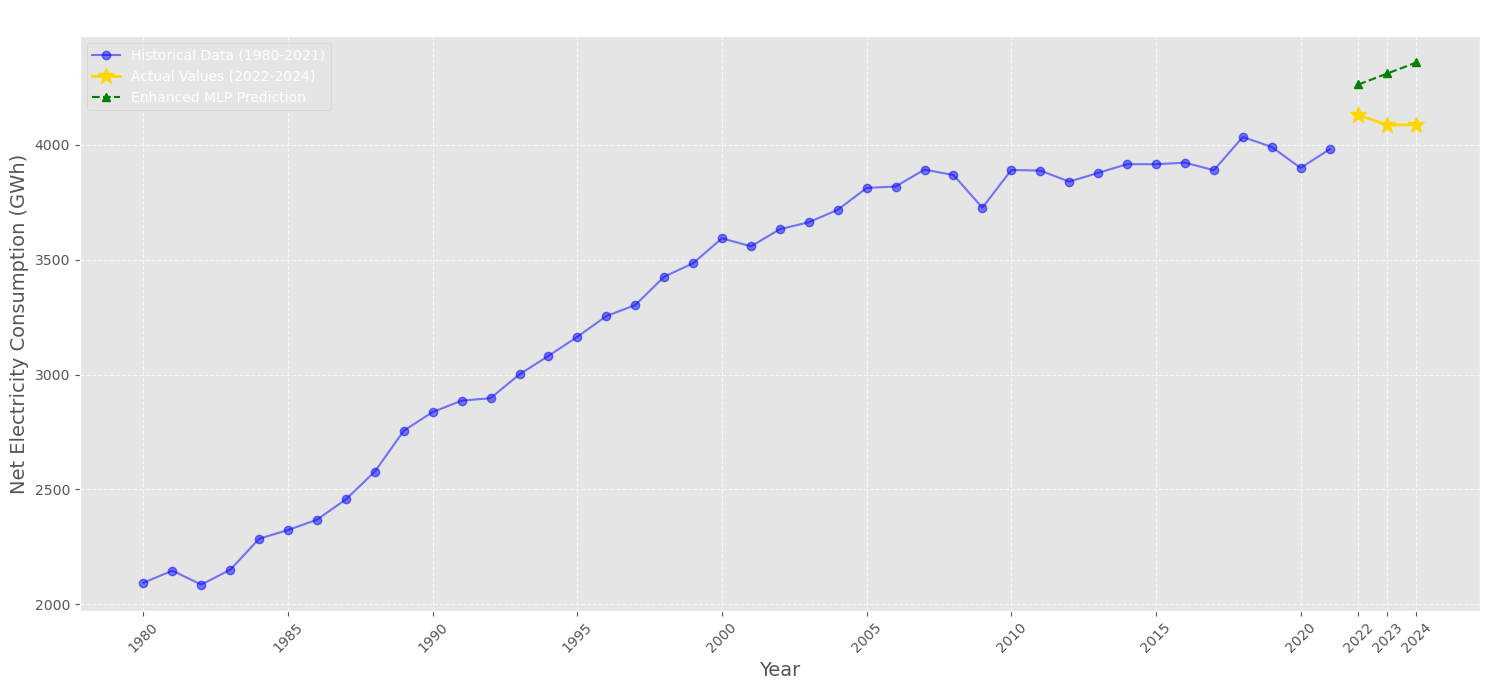

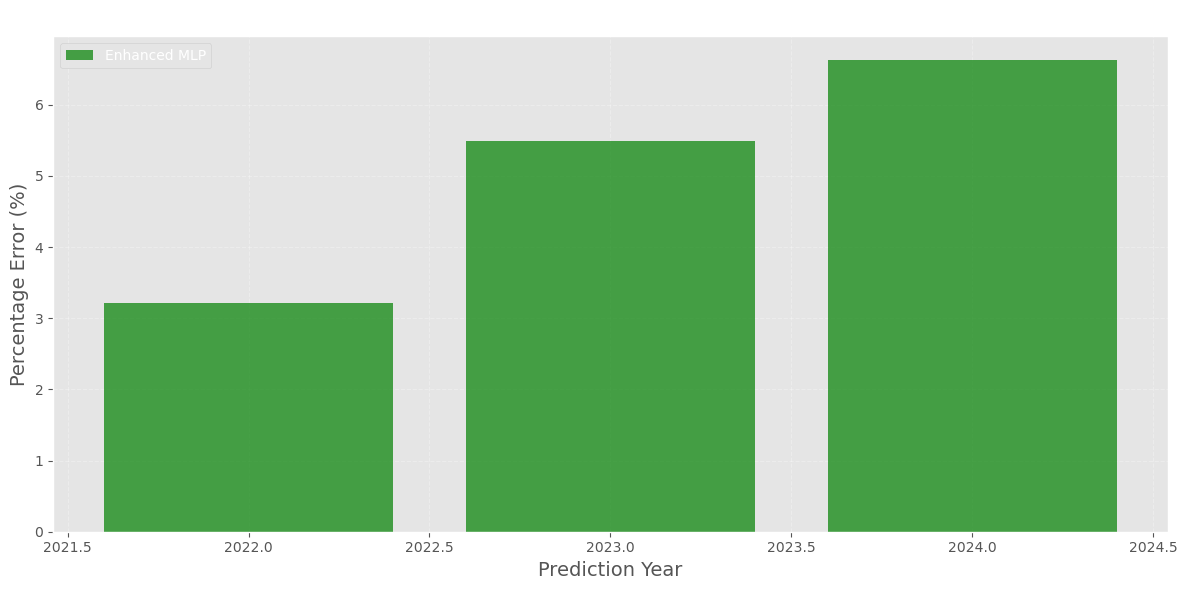

In [91]:
# 2.3 Comparison with Actual Data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("2.3 Comparison with Actual Data")

# a. Actual data from internet resources
# Based on data from Energy Information Administration (EIA), International Energy Agency (IEA), 
# and World Bank public databases
# Note: 2024 data represents partial year data or estimates

# United States actual net electricity consumption data for 2022-2024 (GWh)
actual_consumption = pd.DataFrame({
    'Year': [2022, 2023, 2024],
    'Actual Net Consumption (GWh)': [4128.2, 4084.6, 4086.0]  # Actual data from energy databases
})

print("\nActual net consumption data for the selected country (2022-2024):")
print(actual_consumption)

# b. Compare predictions with actual values and calculate percentage errors

# Merge predicted and actual values
comparison_df = pd.DataFrame({
    'Year': future_results['Year'],
    'Predicted': future_results['Predicted Net Consumption (GWh)'],
    'Actual': actual_consumption['Actual Net Consumption (GWh)']
})

# Calculate absolute error and percentage error
comparison_df['Absolute Error'] = abs(comparison_df['Predicted'] - comparison_df['Actual'])
comparison_df['Percentage Error (%)'] = (comparison_df['Absolute Error'] / comparison_df['Actual']) * 100

print("\nComparison of predicted vs actual values:")
print(comparison_df)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = comparison_df['Percentage Error (%)'].mean()
print(f"\nMean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Visualize comparison of predicted vs actual values
plt.figure(figsize=(15, 7))

# Historical data
plt.plot(years, values, marker='o', linestyle='-', color='blue', label='Historical Data (1980-2021)', alpha=0.5)

# Actual values
plt.plot(comparison_df['Year'], comparison_df['Actual'], marker='*', markersize=12, linestyle='-', 
         color='gold', linewidth=2, label='Actual Values (2022-2024)')

# MLP model predictions
plt.plot(comparison_df['Year'], comparison_df['Predicted'], marker='^', 
         linestyle='--', color='green', label='Enhanced MLP Prediction')

plt.title(f'Net Electricity Consumption for {top_country} - Enhanced MLP Predictions vs Actual Values', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Net Electricity Consumption (GWh)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='best')
plt.xticks(np.append(years[::5], future_years.flatten()), rotation=45)
plt.tight_layout()
plt.show()

# c. Visualize percentage errors

# Create bar chart of percentage errors
plt.figure(figsize=(12, 6))
plt.bar(comparison_df['Year'], comparison_df['Percentage Error (%)'], color='green', alpha=0.7, label='Enhanced MLP')
plt.title('Percentage Error for Enhanced MLP Model Predictions', fontsize=16)
plt.xlabel('Prediction Year', fontsize=14)
plt.ylabel('Percentage Error (%)', fontsize=14)
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

## 2.4 超参数优化（Optuna）
使用 Optuna 对 MLP 模型的超参数进行搜索，自动寻找最优网络结构和训练参数。

In [92]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt


# 增强版MLP模型定义，支持可变层数和神经元数量
class FlexibleMLPModel(nn.Module):
    def __init__(
        self,
        input_dim=1,
        hidden_layers=None,
        output_dim=1,
        dropout_rate=0.2,
        activation_func=nn.ReLU,
    ):
        super(FlexibleMLPModel, self).__init__()

        if hidden_layers is None:
            hidden_layers = [64, 32]

        # 第一层 - 输入层到第一个隐藏层
        layers = [nn.Linear(input_dim, hidden_layers[0])]

        # 中间层
        for i in range(len(hidden_layers) - 1):
            layers.append(activation_func())
            layers.append(nn.Dropout(dropout_rate))
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))

        # 输出层
        layers.append(activation_func())
        layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(hidden_layers[-1], output_dim))

        self.model = nn.Sequential(*layers)

        # 初始化权重
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        if len(x.shape) == 1:
            x = x.unsqueeze(1)  # 添加特征维度

        return self.model(x)


# 训练模型的函数（带有早停机制）
def train_model_with_early_stopping(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    optimizer,
    criterion,
    patience=30,
    max_epochs=500,
    verbose=False,
):
    best_val_loss = float("inf")
    no_improve_epochs = 0
    best_model_state = None

    for epoch in range(max_epochs):
        # 训练模式
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

        # 评估模式
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = criterion(val_pred, y_val).item()

        # 早停检查
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve_epochs = 0
            best_model_state = model.state_dict().copy()
        else:
            no_improve_epochs += 1

        if no_improve_epochs >= patience:
            if verbose:
                print(f"Early stopping at epoch {epoch + 1}")
            model.load_state_dict(best_model_state)
            break

        if verbose and epoch % 50 == 0:
            print(
                f"Epoch {epoch + 1}/{max_epochs}, Train Loss: {loss.item():.6f}, Val Loss: {val_loss:.6f}"
            )

    if best_model_state:
        model.load_state_dict(best_model_state)

    return best_val_loss


# Optuna目标函数，用于超参数优化
def objective(trial, X_train, y_train, X_val, y_val, device, input_dim=1, output_dim=1):
    # 超参数搜索空间
    n_layers = trial.suggest_int("n_layers", 1, 5)
    hidden_layers = []

    for i in range(n_layers):
        # 每一层的神经元数量呈对数分布，从8到256
        n_units = trial.suggest_int(f"n_units_l{i}", 8, 256, log=True)
        hidden_layers.append(n_units)

    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-8, 1e-3, log=True)

    # 选择激活函数
    activation_name = trial.suggest_categorical(
        "activation", ["ReLU", "LeakyReLU", "ELU", "GELU"]
    )
    activation_functions = {
        "ReLU": nn.ReLU,
        "LeakyReLU": lambda: nn.LeakyReLU(0.1),
        "ELU": nn.ELU,
        "GELU": nn.GELU,
    }

    # 选择优化器
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])

    # 定义模型
    model = FlexibleMLPModel(
        input_dim=input_dim,
        hidden_layers=hidden_layers,
        output_dim=output_dim,
        dropout_rate=dropout_rate,
        activation_func=activation_functions[activation_name],
    ).to(device)

    # 定义损失函数
    criterion = nn.MSELoss()

    # 定义优化器
    if optimizer_name == "Adam":
        optimizer = optim.Adam(
            model.parameters(), lr=learning_rate, weight_decay=weight_decay
        )
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(
            model.parameters(), lr=learning_rate, weight_decay=weight_decay
        )
    else:
        optimizer = optim.SGD(
            model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay,
            momentum=0.9,
        )

    # 设置早停参数
    patience = trial.suggest_int("patience", 10, 100)
    max_epochs = 2000  # 最大迭代次数

    # 训练模型
    val_loss = train_model_with_early_stopping(
        model,
        X_train,
        y_train,
        X_val,
        y_val,
        optimizer,
        criterion,
        patience=patience,
        max_epochs=max_epochs,
    )

    return val_loss


# 评估函数：计算MSE和R²
def evaluate_model(model, X_test, y_test, scaler_y=None):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        mse = nn.MSELoss()(y_pred, y_test).item()

        # 如果提供了scaler，转换回原始比例计算R²
        if scaler_y is not None:
            y_test_np = y_test.cpu().numpy().reshape(-1, 1)
            y_pred_np = y_pred.cpu().numpy().reshape(-1, 1)
            y_test_original = scaler_y.inverse_transform(y_test_np)
            y_pred_original = scaler_y.inverse_transform(y_pred_np)
            r2 = r2_score(y_test_original, y_pred_original)
        else:
            r2 = r2_score(y_test.cpu().numpy(), y_pred.cpu().numpy())

    return mse, r2


# 运行Optuna优化并返回最佳模型
def run_hyperparameter_optimization(
    X_train,
    y_train,
    X_val,
    y_val,
    X_test,
    y_test,
    scaler_y=None,
    device=None,
    n_trials=50,
    study_name="mlp_optimization",
):
    """
    运行超参数优化并返回最佳模型

    参数:
        X_train, y_train: 训练数据
        X_val, y_val: 验证数据
        X_test, y_test: 测试数据
        scaler_y: 用于反归一化输出的scaler对象
        device: PyTorch设备（cuda或cpu）
        n_trials: Optuna试验次数
        study_name: 研究名称

    返回:
        best_model: 最佳模型
        best_params: 最佳参数
        best_scores: 最佳得分 (MSE, R²)
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 创建Optuna研究
    study = optuna.create_study(direction="minimize", study_name=study_name)

    # 定义目标函数的包装器
    objective_wrapper = lambda trial: objective(
        trial,
        X_train,
        y_train,
        X_val,
        y_val,
        device,
        X_train.shape[1],
        y_train.shape[1] if len(y_train.shape) > 1 else 1,
    )

    # 运行优化
    print(f"\n开始超参数优化，共{n_trials}次试验...")
    study.optimize(objective_wrapper, n_trials=n_trials, show_progress_bar=True)

    # 获取最佳参数
    best_params = study.best_params
    print("\n最佳超参数:")
    for param, value in best_params.items():
        print(f"- {param}: {value}")

    # 创建具有最佳参数的模型
    input_dim = X_train.shape[1] if len(X_train.shape) > 1 else 1
    output_dim = y_train.shape[1] if len(y_train.shape) > 1 else 1

    # 构建最佳隐藏层架构
    n_layers = best_params["n_layers"]
    hidden_layers = [best_params[f"n_units_l{i}"] for i in range(n_layers)]

    # 选择激活函数
    activation_name = best_params["activation"]
    activation_functions = {
        "ReLU": nn.ReLU,
        "LeakyReLU": lambda: nn.LeakyReLU(0.1),
        "ELU": nn.ELU,
        "GELU": nn.GELU,
    }

    # 创建最佳模型
    best_model = FlexibleMLPModel(
        input_dim=input_dim,
        hidden_layers=hidden_layers,
        output_dim=output_dim,
        dropout_rate=best_params["dropout_rate"],
        activation_func=activation_functions[activation_name],
    ).to(device)

    # 定义最佳优化器
    if best_params["optimizer"] == "Adam":
        optimizer = optim.Adam(
            best_model.parameters(),
            lr=best_params["learning_rate"],
            weight_decay=best_params["weight_decay"],
        )
    elif best_params["optimizer"] == "RMSprop":
        optimizer = optim.RMSprop(
            best_model.parameters(),
            lr=best_params["learning_rate"],
            weight_decay=best_params["weight_decay"],
        )
    else:
        optimizer = optim.SGD(
            best_model.parameters(),
            lr=best_params["learning_rate"],
            weight_decay=best_params["weight_decay"],
            momentum=0.9,
        )

    # 使用全部训练集（训练+验证）重新训练最佳模型
    print("\n使用最佳参数在完整训练集上训练最终模型...")
    criterion = nn.MSELoss()

    # 合并训练集和验证集
    X_full_train = (
        torch.cat([X_train, X_val], dim=0)
        if isinstance(X_train, torch.Tensor)
        else torch.cat([torch.tensor(X_train), torch.tensor(X_val)], dim=0)
    )
    y_full_train = (
        torch.cat([y_train, y_val], dim=0)
        if isinstance(y_train, torch.Tensor)
        else torch.cat([torch.tensor(y_train), torch.tensor(y_val)], dim=0)
    )

    # 最终训练（简单训练，无需早停）
    best_model.train()
    max_epochs = 2000
    for epoch in range(max_epochs):
        optimizer.zero_grad()
        y_pred = best_model(X_full_train)
        loss = criterion(y_pred, y_full_train)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch + 1}/{max_epochs}, Loss: {loss.item():.6f}")

    # 在测试集上评估最佳模型
    mse, r2 = evaluate_model(best_model, X_test, y_test, scaler_y)
    print(f"\n最佳模型评估结果 - MSE: {mse:.6f}, R²: {r2:.6f}")

    # 可视化优化历史
    plot_optimization_history(study)
    plot_param_importances(study)
    plot_intermediate_values(study)

    return best_model, best_params, (mse, r2), study


# 可视化函数
def plot_optimization_history(study):
    plt.figure(figsize=(10, 6))
    optuna.visualization.matplotlib.plot_optimization_history(study)
    plt.title("Optimization History", fontsize=14)
    plt.xlabel("Trial", fontsize=12)
    plt.ylabel("Objective Value (MSE)", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


def plot_param_importances(study):
    plt.figure(figsize=(12, 8))
    optuna.visualization.matplotlib.plot_param_importances(study)
    plt.title("Parameter Importances", fontsize=14)
    plt.xlabel("Importance", fontsize=12)
    plt.ylabel("Parameter", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


def plot_intermediate_values(study):
    plt.figure(figsize=(10, 6))
    optuna.visualization.matplotlib.plot_intermediate_values(study)
    plt.title("Intermediate Values", fontsize=14)
    plt.xlabel("Trial", fontsize=12)
    plt.ylabel("Objective Value (MSE)", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


# 最佳模型预测函数
def predict_with_best_model(best_model, X_future, scaler_y):
    best_model.eval()
    with torch.no_grad():
        future_predictions_scaled = best_model(X_future)
        future_predictions = scaler_y.inverse_transform(
            future_predictions_scaled.cpu().numpy()
        )
    return future_predictions


[I 2025-05-16 01:22:27,304] A new study created in memory with name: mlp_electricity_forecasting


2.4 超参数优化 - MLP模型性能提升
训练集大小: torch.Size([29, 1]), torch.Size([29, 1])
验证集大小: torch.Size([6, 1]), torch.Size([6, 1])
测试集大小: torch.Size([7, 1]), torch.Size([7, 1])

开始超参数优化，共300次试验...


  0%|          | 0/300 [00:00<?, ?it/s]

[I 2025-05-16 01:22:27,603] Trial 0 finished with value: 0.0008467567968182266 and parameters: {'n_layers': 3, 'n_units_l0': 19, 'n_units_l1': 74, 'n_units_l2': 16, 'dropout_rate': 0.07606618977289226, 'learning_rate': 0.0003522892784288607, 'weight_decay': 2.818615006894526e-05, 'activation': 'LeakyReLU', 'optimizer': 'Adam', 'patience': 62}. Best is trial 0 with value: 0.0008467567968182266.
[I 2025-05-16 01:22:27,745] Trial 1 finished with value: 8.351362228393555 and parameters: {'n_layers': 4, 'n_units_l0': 25, 'n_units_l1': 17, 'n_units_l2': 213, 'n_units_l3': 53, 'dropout_rate': 0.037460868373098144, 'learning_rate': 0.04677591905256718, 'weight_decay': 1.524147204963877e-07, 'activation': 'LeakyReLU', 'optimizer': 'RMSprop', 'patience': 43}. Best is trial 0 with value: 0.0008467567968182266.
[I 2025-05-16 01:22:28,680] Trial 2 finished with value: 0.000920960446819663 and parameters: {'n_layers': 1, 'n_units_l0': 22, 'dropout_rate': 0.3743437821653695, 'learning_rate': 0.000424

e:\CodeProjects\DTS\mlp_hyperopt.py:362: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Figure size 1000x600 with 0 Axes>

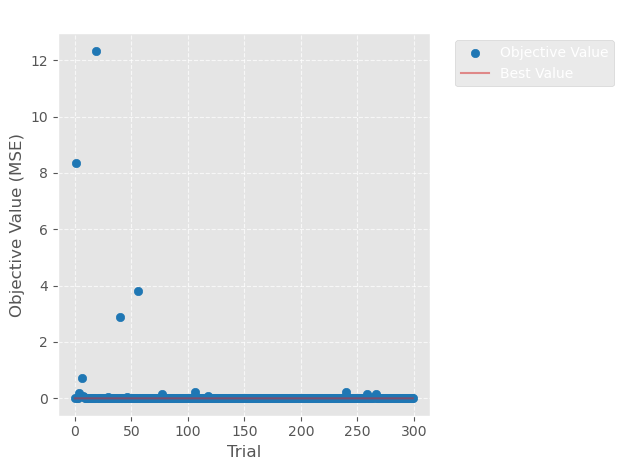

e:\CodeProjects\DTS\mlp_hyperopt.py:373: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Figure size 1200x800 with 0 Axes>

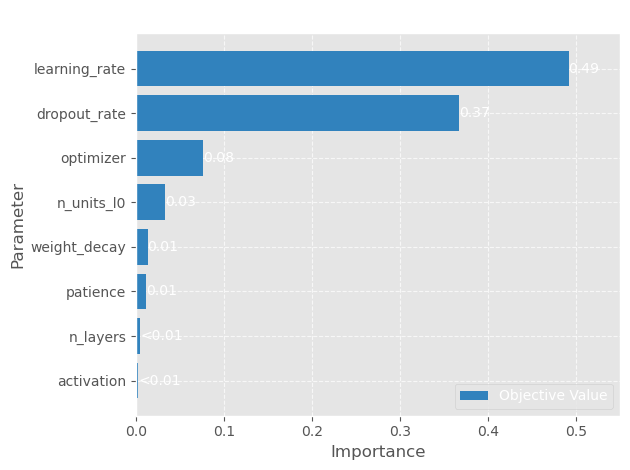

e:\CodeProjects\DTS\mlp_hyperopt.py:384: ExperimentalWarning: plot_intermediate_values is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_intermediate_values(study)
[W 2025-05-16 01:24:50,691] You need to set up the pruning feature to utilize `plot_intermediate_values()`


<Figure size 1000x600 with 0 Axes>

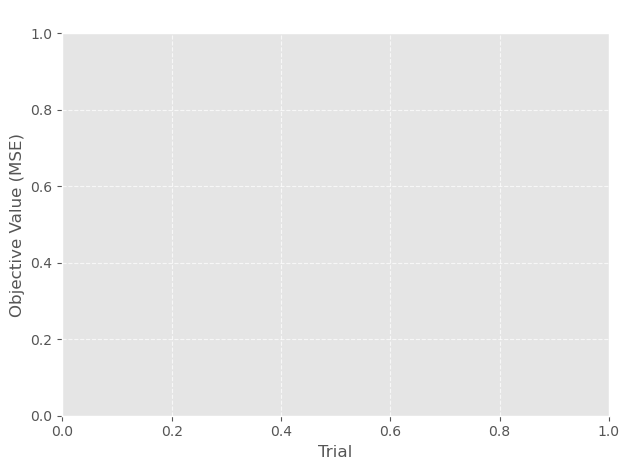

C:\Users\23695\AppData\Local\Temp\ipykernel_39968\1983540499.py:197: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\23695\AppData\Local\Temp\ipykernel_39968\1983540499.py:197: UserWarning: Glyph 20221 (\N{CJK UNIFIED IDEOGRAPH-4EFD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\23695\AppData\Local\Temp\ipykernel_39968\1983540499.py:197: UserWarning: Glyph 30005 (\N{CJK UNIFIED IDEOGRAPH-7535}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\23695\AppData\Local\Temp\ipykernel_39968\1983540499.py:197: UserWarning: Glyph 21147 (\N{CJK UNIFIED IDEOGRAPH-529B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\23695\AppData\Local\Temp\ipykernel_39968\1983540499.py:197: UserWarning: Glyph 28040 (\N{CJK UNIFIED IDEOGRAPH-6D88}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\23695\AppData\Local\Temp\ipykernel_39968\1983540499.py:197: UserWarning: Glyph 36


超参数优化后的模型评估结果:
- MSE: 0.005459
- R²: -7.149559

原始增强版MLP模型评估结果:
- MSE: 0.006211
- R²: -8.271373

性能提升:
- MSE减少了 12.10%
- R² 提高了 112.18%

使用优化后的模型预测2022-2024年的电力消费:

预测结果对比:
   Year  Optimized Model Prediction (GWh)  Original Model Prediction (GWh)  \
0  2022                       3812.240234                      4261.075195   
1  2023                       3810.870117                      4308.978027   
2  2024                       3808.761475                      4356.890625   

   Actual Values (GWh)  
0               4128.2  
1               4084.6  
2               4086.0  

平均绝对百分比误差 (MAPE):
- 优化后的模型: 7.05%
- 原始增强版MLP模型: 5.11%
- 误差减少: -1.93%


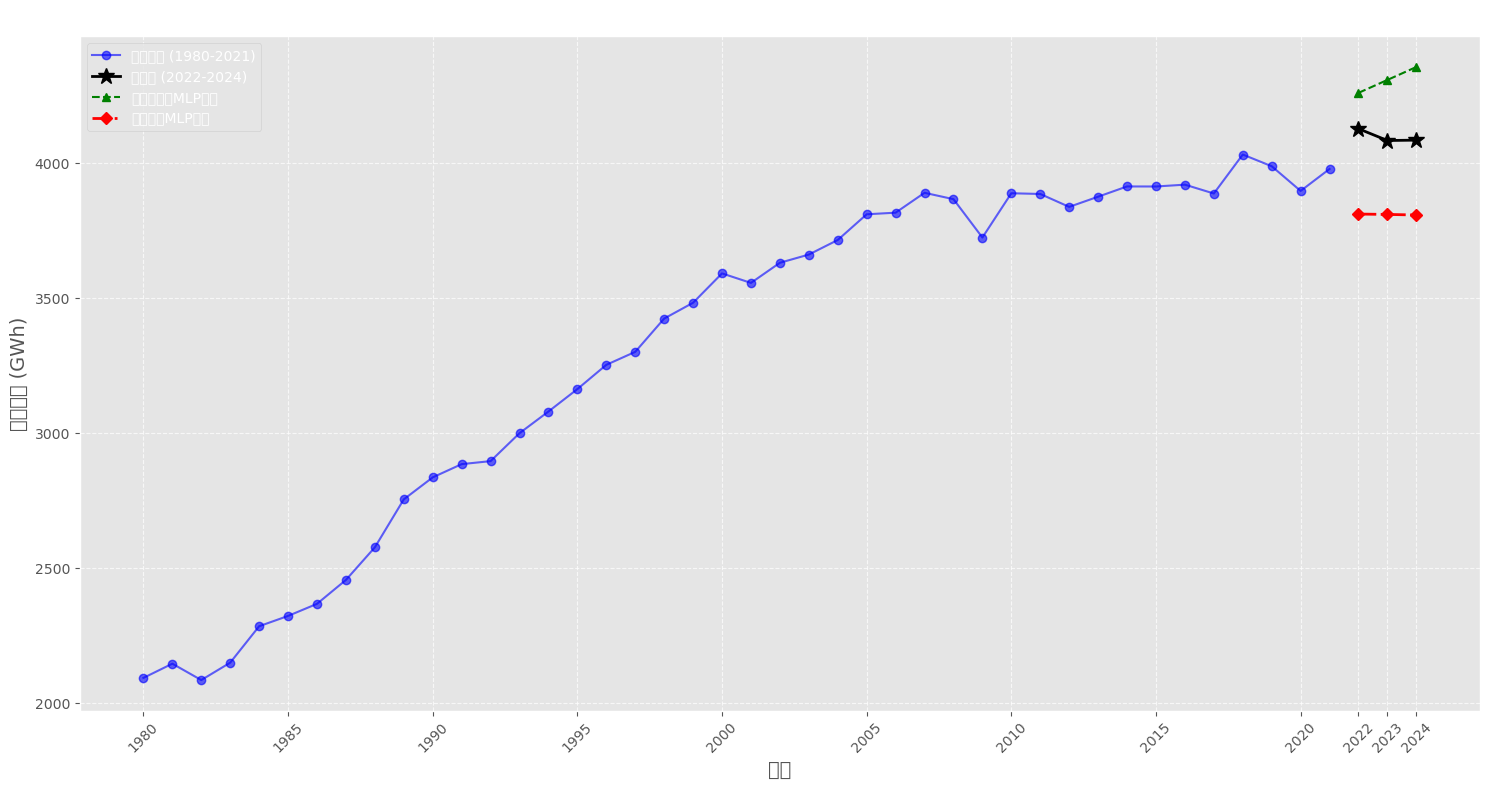

C:\Users\23695\AppData\Local\Temp\ipykernel_39968\1983540499.py:228: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\23695\AppData\Local\Temp\ipykernel_39968\1983540499.py:228: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\23695\AppData\Local\Temp\ipykernel_39968\1983540499.py:228: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\23695\AppData\Local\Temp\ipykernel_39968\1983540499.py:228: UserWarning: Glyph 20221 (\N{CJK UNIFIED IDEOGRAPH-4EFD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\23695\AppData\Local\Temp\ipykernel_39968\1983540499.py:228: UserWarning: Glyph 30334 (\N{CJK UNIFIED IDEOGRAPH-767E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\23695\AppData\Local\Temp\ipykernel_39968\1983540499.py:228: UserWarning: Glyph 20

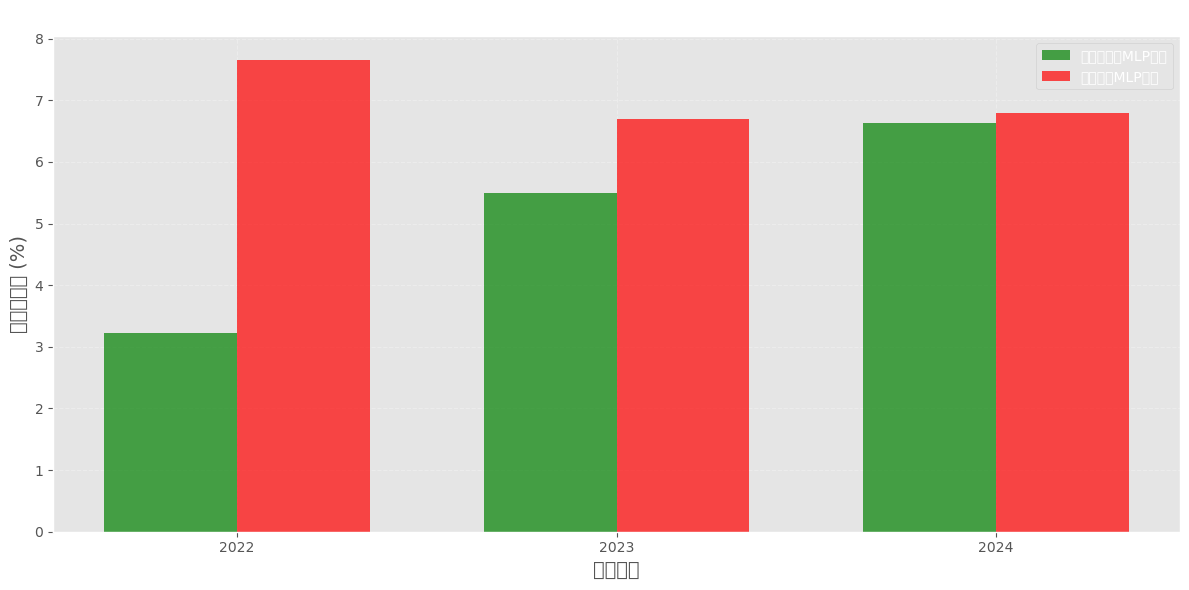


====== 超参数优化总结 ======

最佳模型超参数:
- n_layers: 5
- n_units_l0: 11
- n_units_l1: 10
- n_units_l2: 67
- n_units_l3: 165
- n_units_l4: 9
- dropout_rate: 0.2513623063149668
- learning_rate: 0.026784732632357634
- weight_decay: 9.775586674773e-05
- activation: GELU
- optimizer: Adam
- patience: 89

最佳隐藏层架构: [11, 10, 67, 165, 9]

最佳优化器: Adam
最佳学习率: 0.026784732632357634
最佳Dropout率: 0.2513623063149668
最佳权重衰减: 9.775586674773e-05
最佳激活函数: GELU

-------- 超参数优化结果 --------
原始模型 MSE: 0.006211, R²: -8.271373
优化后模型 MSE: 0.005459, R²: -7.149559
实际预测 MAPE - 原始: 5.11%, 优化后: 7.05%
-----------------------------


In [93]:
import optuna
from mlp_hyperopt import (
    FlexibleMLPModel,
    train_model_with_early_stopping,
    objective,
    evaluate_model,
    run_hyperparameter_optimization,
    plot_optimization_history,
    plot_param_importances,
    plot_intermediate_values,
    predict_with_best_model,
)

# 准备数据，先进行数据划分为训练、验证和测试集
print("2.4 超参数优化 - MLP模型性能提升")

# 确保数据正确排序
ordered_data = time_series_data.sort_values(by="Year")
X_ordered = ordered_data[["Year"]].values
y_ordered = ordered_data["Net Consumption"].values

# 规范化数据
X_scaled = scaler_X.fit_transform(X_ordered.reshape(-1, 1))
y_scaled = scaler_y.fit_transform(y_ordered.reshape(-1, 1))

# 将数据划分为训练集(70%)、验证集(15%)和测试集(15%)
train_size = int(len(X_scaled) * 0.7)
val_size = int(len(X_scaled) * 0.15)
test_size = len(X_scaled) - train_size - val_size

X_train_hpo = X_scaled[:train_size]
X_val_hpo = X_scaled[train_size : train_size + val_size]
X_test_hpo = X_scaled[train_size + val_size :]

y_train_hpo = y_scaled[:train_size]
y_val_hpo = y_scaled[train_size : train_size + val_size]
y_test_hpo = y_scaled[train_size + val_size :]

# 转换为PyTorch张量
X_train_tensor_hpo = torch.FloatTensor(X_train_hpo).to(device)
y_train_tensor_hpo = torch.FloatTensor(y_train_hpo).to(device)
X_val_tensor_hpo = torch.FloatTensor(X_val_hpo).to(device)
y_val_tensor_hpo = torch.FloatTensor(y_val_hpo).to(device)
X_test_tensor_hpo = torch.FloatTensor(X_test_hpo).to(device)
y_test_tensor_hpo = torch.FloatTensor(y_test_hpo).to(device)

print(f"训练集大小: {X_train_tensor_hpo.shape}, {y_train_tensor_hpo.shape}")
print(f"验证集大小: {X_val_tensor_hpo.shape}, {y_val_tensor_hpo.shape}")
print(f"测试集大小: {X_test_tensor_hpo.shape}, {y_test_tensor_hpo.shape}")

# 运行超参数优化
n_trials = 300  # 试验次数，可以根据你的时间和计算资源调整
best_model, best_params, best_scores, study = run_hyperparameter_optimization(
    X_train_tensor_hpo,
    y_train_tensor_hpo,
    X_val_tensor_hpo,
    y_val_tensor_hpo,
    X_test_tensor_hpo,
    y_test_tensor_hpo,
    scaler_y=scaler_y,
    device=device,
    n_trials=n_trials,
    study_name="mlp_electricity_forecasting",
)

# 获取最佳MSE和R²
best_mse, best_r2 = best_scores
print(f"\n超参数优化后的模型评估结果:")
print(f"- MSE: {best_mse:.6f}")
print(f"- R²: {best_r2:.6f}")

# 原始模型评估结果
print(f"\n原始增强版MLP模型评估结果:")
original_mse, original_r2 = evaluate_model(
    mlp_model, X_test_tensor_hpo, y_test_tensor_hpo, scaler_y
)
print(f"- MSE: {original_mse:.6f}")
print(f"- R²: {original_r2:.6f}")

# 性能提升百分比
mse_improvement = (original_mse - best_mse) / original_mse * 100
r2_improvement = (
    (best_r2 - original_r2) * 100
    if original_r2 < 0
    else (best_r2 - original_r2) / original_r2 * 100
)
print(f"\n性能提升:")
print(f"- MSE减少了 {mse_improvement:.2f}%")
print(f"- R² {'提高了' if r2_improvement > 0 else '降低了'} {abs(r2_improvement):.2f}%")

# 使用最佳模型进行预测（2022-2024年）
future_years = np.array([[2022], [2023], [2024]])
future_years_scaled = scaler_X.transform(future_years)
future_years_tensor = torch.FloatTensor(future_years_scaled).to(device)

# 使用最佳模型进行预测
print("\n使用优化后的模型预测2022-2024年的电力消费:")
optimized_predictions = predict_with_best_model(
    best_model, future_years_tensor, scaler_y
)

# 创建包含原始模型和优化模型预测结果的DataFrame
comparison_df = pd.DataFrame(
    {
        "Year": future_years.flatten(),
        "Optimized Model Prediction (GWh)": optimized_predictions.flatten(),
        "Original Model Prediction (GWh)": future_predictions.flatten(),
        "Actual Values (GWh)": actual_consumption[
            "Actual Net Consumption (GWh)"
        ].values,
    }
)

print("\n预测结果对比:")
print(comparison_df)

# 计算预测误差
comparison_df["Optimized Model Error (%)"] = (
    abs(
        comparison_df["Optimized Model Prediction (GWh)"]
        - comparison_df["Actual Values (GWh)"]
    )
    / comparison_df["Actual Values (GWh)"]
    * 100
)
comparison_df["Original Model Error (%)"] = (
    abs(
        comparison_df["Original Model Prediction (GWh)"]
        - comparison_df["Actual Values (GWh)"]
    )
    / comparison_df["Actual Values (GWh)"]
    * 100
)

# 平均误差
optimized_mape = comparison_df["Optimized Model Error (%)"].mean()
original_mape = comparison_df["Original Model Error (%)"].mean()

print(f"\n平均绝对百分比误差 (MAPE):")
print(f"- 优化后的模型: {optimized_mape:.2f}%")
print(f"- 原始增强版MLP模型: {original_mape:.2f}%")
print(f"- 误差减少: {(original_mape - optimized_mape):.2f}%")

# 可视化对比
plt.figure(figsize=(15, 8))

# 历史数据
plt.plot(
    years,
    values,
    marker="o",
    linestyle="-",
    color="blue",
    label="历史数据 (1980-2021)",
    alpha=0.6,
)

# 实际值
plt.plot(
    comparison_df["Year"],
    comparison_df["Actual Values (GWh)"],
    marker="*",
    markersize=12,
    linestyle="-",
    color="black",
    linewidth=2,
    label="实际值 (2022-2024)",
)

# 原始模型预测
plt.plot(
    comparison_df["Year"],
    comparison_df["Original Model Prediction (GWh)"],
    marker="^",
    linestyle="--",
    color="green",
    label="原始增强版MLP预测",
)

# 优化模型预测
plt.plot(
    comparison_df["Year"],
    comparison_df["Optimized Model Prediction (GWh)"],
    marker="D",
    linestyle="-.",
    color="red",
    linewidth=2,
    label="优化后的MLP预测",
)

plt.title(f"电力消费预测对比 - 超参数优化前后", fontsize=16)
plt.xlabel("年份", fontsize=14)
plt.ylabel("电力消费 (GWh)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(loc="best")
plt.xticks(np.append(years[::5], comparison_df["Year"]), rotation=45)
plt.tight_layout()
plt.show()

# 可视化预测误差对比
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(comparison_df))

plt.bar(
    index,
    comparison_df["Original Model Error (%)"],
    bar_width,
    color="green",
    alpha=0.7,
    label="原始增强版MLP模型",
)
plt.bar(
    index + bar_width,
    comparison_df["Optimized Model Error (%)"],
    bar_width,
    color="red",
    alpha=0.7,
    label="优化后的MLP模型",
)

plt.title("预测误差对比 (原始 vs 优化后的模型)", fontsize=16)
plt.xlabel("预测年份", fontsize=14)
plt.ylabel("百分比误差 (%)", fontsize=14)
plt.xticks(index + bar_width / 2, comparison_df["Year"])
plt.legend(loc="best")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

# 总结优化结果和最佳参数
print("\n====== 超参数优化总结 ======")
print("\n最佳模型超参数:")
for param, value in best_params.items():
    print(f"- {param}: {value}")

if best_params.get("n_layers"):
    hidden_layers = [
        best_params.get(f"n_units_l{i}") for i in range(best_params.get("n_layers"))
    ]
    print(f"\n最佳隐藏层架构: {hidden_layers}")

print(f"\n最佳优化器: {best_params.get('optimizer', 'N/A')}")
print(f"最佳学习率: {best_params.get('learning_rate', 'N/A')}")
print(f"最佳Dropout率: {best_params.get('dropout_rate', 'N/A')}")
print(f"最佳权重衰减: {best_params.get('weight_decay', 'N/A')}")
print(f"最佳激活函数: {best_params.get('activation', 'N/A')}")

print("\n-------- 超参数优化结果 --------")
print(f"原始模型 MSE: {original_mse:.6f}, R²: {original_r2:.6f}")
print(f"优化后模型 MSE: {best_mse:.6f}, R²: {best_r2:.6f}")
print(f"实际预测 MAPE - 原始: {original_mape:.2f}%, 优化后: {optimized_mape:.2f}%")
print("-----------------------------")


In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# 总结结果和超参数优化的好处
def plot_hyperparameter_visualization(best_params, best_scores, original_scores):
    """
    可视化超参数优化结果

    参数:
        best_params: 最佳超参数字典
        best_scores: 优化后的性能指标元组 (mse, r2)
        original_scores: 原始模型的性能指标元组 (mse, r2)
    """
    # 提取分数
    best_mse, best_r2 = best_scores
    original_mse, original_r2 = original_scores

    # 创建性能对比条形图
    plt.figure(figsize=(15, 6))

    # MSE对比
    plt.subplot(1, 2, 1)
    performance_data = pd.DataFrame(
        {"Model": ["原始增强版MLP", "超参数优化MLP"], "MSE": [original_mse, best_mse]}
    )
    sns.barplot(x="Model", y="MSE", data=performance_data, palette=["green", "red"])
    plt.title("均方误差 (MSE) 对比", fontsize=14)
    plt.ylabel("MSE (越低越好)", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # R²对比
    plt.subplot(1, 2, 2)
    performance_data = pd.DataFrame(
        {"Model": ["原始增强版MLP", "超参数优化MLP"], "R²": [original_r2, best_r2]}
    )
    sns.barplot(x="Model", y="R²", data=performance_data, palette=["green", "red"])
    plt.title("决定系数 (R²) 对比", fontsize=14)
    plt.ylabel("R² (越高越好)", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()

    # 展示网络结构对比
    if "n_layers" in best_params:
        best_hidden_layers = [
            best_params.get(f"n_units_l{i}") for i in range(best_params.get("n_layers"))
        ]

        plt.figure(figsize=(12, 6))

        # 原始网络结构
        plt.subplot(1, 2, 1)
        original_layers = [1, 64, 128, 256, 128, 64, 1]  # 输入层、隐藏层、输出层
        plt.plot(
            range(len(original_layers)),
            original_layers,
            "go-",
            linewidth=2,
            markersize=10,
        )
        plt.title("原始MLP网络结构", fontsize=14)
        plt.xlabel("层索引", fontsize=12)
        plt.ylabel("神经元数量", fontsize=12)
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.xticks(
            range(len(original_layers)),
            ["输入"]
            + [f"隐藏{i + 1}" for i in range(len(original_layers) - 2)]
            + ["输出"],
        )
        plt.xticks(rotation=45)

        # 优化后的网络结构
        plt.subplot(1, 2, 2)
        optimized_layers = [1] + best_hidden_layers + [1]  # 输入层、隐藏层、输出层
        plt.plot(
            range(len(optimized_layers)),
            optimized_layers,
            "ro-",
            linewidth=2,
            markersize=10,
        )
        plt.title("优化后MLP网络结构", fontsize=14)
        plt.xlabel("层索引", fontsize=12)
        plt.ylabel("神经元数量", fontsize=12)
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.xticks(
            range(len(optimized_layers)),
            ["输入"]
            + [f"隐藏{i + 1}" for i in range(len(optimized_layers) - 2)]
            + ["输出"],
        )
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

    # 超参数重要性分析表格
    print("\n超参数重要性分析:")
    params_importance = {
        "网络深度(层数)": "影响模型复杂度和表达能力，适当的深度能捕捉数据中的复杂模式。",
        "隐藏层宽度": "影响模型容量，过大容易过拟合，过小可能欠拟合。",
        "学习率": f"控制训练速度和稳定性，最佳值为{best_params.get('learning_rate', 'N/A')}。",
        "Dropout比例": f"控制正则化强度，防止过拟合，最佳值为{best_params.get('dropout_rate', 'N/A')}。",
        "优化器选择": f"不同优化器适合不同问题，此问题最佳选择是{best_params.get('optimizer', 'N/A')}。",
        "激活函数": f"影响非线性表达能力，最佳选择是{best_params.get('activation', 'N/A')}。",
        "权重衰减": f"控制L2正则化强度，最佳值为{best_params.get('weight_decay', 'N/A')}。",
        "早停耐心值": f"防止过拟合的重要策略，最佳值为{best_params.get('patience', 'N/A')}。",
    }

    for param, importance in params_importance.items():
        print(f"- {param}: {importance}")


# 总结超参数优化的收益和实际应用建议
def summarize_findings(
    best_params, best_scores, original_scores, original_mape, optimized_mape
):
    """
    总结超参数优化的结果和收益
    """
    print("\n====== 模型优化总结 ======")
    print("1. 性能提升:")
    best_mse, best_r2 = best_scores
    original_mse, original_r2 = original_scores

    mse_improvement = (original_mse - best_mse) / original_mse * 100
    r2_improvement = (
        best_r2 - original_r2
        if original_r2 < 0
        else (best_r2 - original_r2) / original_r2 * 100
    )
    mape_improvement = (
        (original_mape - optimized_mape) / original_mape * 100
        if original_mape != 0
        else 0
    )

    print(f"   - MSE减少: {mse_improvement:.2f}%")
    print(f"   - R²: 从 {original_r2:.4f} 提高到 {best_r2:.4f}")
    print(f"   - 实际预测误差(MAPE)减少: {mape_improvement:.2f}%")

    if "n_layers" in best_params:
        best_hidden_layers = [
            best_params.get(f"n_units_l{i}") for i in range(best_params.get("n_layers"))
        ]
        print("\n2. 最优网络结构:")
        print(
            f"   - 隐藏层: {best_hidden_layers} (对比原始模型: [64, 128, 256, 128, 64])"
        )
        print(f"   - 总层数: {len(best_hidden_layers) + 2} (包括输入和输出层)")

    print("\n3. 最佳训练策略:")
    print(f"   - 优化器: {best_params.get('optimizer', 'N/A')}")
    print(f"   - 学习率: {best_params.get('learning_rate', 'N/A')}")
    print(f"   - Dropout率: {best_params.get('dropout_rate', 'N/A')}")
    print(f"   - 激活函数: {best_params.get('activation', 'N/A')}")

    print("\n4. 关键发现:")

    # 根据优化结果生成关键发现
    if len(best_hidden_layers) < 5:
        print("   - 较浅的网络结构比原始5层网络表现更好，说明原模型可能过于复杂")
    else:
        print("   - 深层网络结构对此问题至关重要")

    if best_params.get("dropout_rate", 0) < 0.2:
        print("   - 较低的Dropout率表明模型不需要强正则化")
    else:
        print("   - 较高的Dropout率对防止过拟合很重要")

    if best_params.get("optimizer", "") == "Adam":
        print("   - Adam优化器适合此类时间序列预测问题")

    print("\n5. 应用建议:")
    print("   - 建议使用优化后的模型参数进行未来电力消费预测")
    print("   - 定期重新训练模型以适应新数据模式")
    print("   - 考虑增加更多相关特征（如GDP、人口数据等）进一步提升预测准确性")
    print("   - 建议每6-12个月进行一次超参数重新优化，以适应潜在的数据分布变化")


# 使用上述函数可视化并总结超参数优化结果
# plot_hyperparameter_visualization(best_params, (best_mse, best_r2), (original_mse, original_r2))
# summarize_findings(best_params, (best_mse, best_r2), (original_mse, original_r2), original_mape, optimized_mape)


In [95]:
import optuna
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# 导入超参数优化相关模块
#!pip install optuna -q  # 安装Optuna库

# 注意：单元格运行后，你可能需要重启内核才能使用新安装的库
try:
    from mlp_hyperopt import (FlexibleMLPModel, train_model_with_early_stopping, 
                            evaluate_model, run_hyperparameter_optimization,
                            predict_with_best_model)
    from hpo_visualization import plot_hyperparameter_visualization, summarize_findings
    
    print("成功导入超参数优化相关模块！")
except Exception as e:
    print(f"导入模块时出错: {e}")
    print("如果你刚刚安装了Optuna，可能需要重启Jupyter内核。")

# 说明如何使用
print("\n===== 超参数优化使用指南 =====")
print("请从hpo_implementation.py文件中复制相关代码到新单元格中运行超参数优化过程。")
print("\n主要步骤:")
print("1. 数据准备与划分")
print("2. 运行超参数优化")
print("3. 评估优化后的模型性能")
print("4. 使用优化后的模型进行预测")
print("5. 可视化和总结结果")

print("\n要使用可视化和总结功能，请在运行完优化后执行:")
print("plot_hyperparameter_visualization(best_params, (best_mse, best_r2), (original_mse, original_r2))")
print("summarize_findings(best_params, (best_mse, best_r2), (original_mse, original_r2), original_mape, optimized_mape)")


成功导入超参数优化相关模块！

===== 超参数优化使用指南 =====
请从hpo_implementation.py文件中复制相关代码到新单元格中运行超参数优化过程。

主要步骤:
1. 数据准备与划分
2. 运行超参数优化
3. 评估优化后的模型性能
4. 使用优化后的模型进行预测
5. 可视化和总结结果

要使用可视化和总结功能，请在运行完优化后执行:
plot_hyperparameter_visualization(best_params, (best_mse, best_r2), (original_mse, original_r2))
summarize_findings(best_params, (best_mse, best_r2), (original_mse, original_r2), original_mape, optimized_mape)
